# Import necessary packages and change display settings

In [57]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook" # Let's us display Plotly figs after export to html file 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format # display numbers as with thousands separator
pd.set_option('display.max_colwidth', None) # display full text in columns

# Create Excel file to store data
import openpyxl
wb = openpyxl.Workbook()
wb.save("Data/earnings_tables.xlsx")

from IPython.display import display, HTML

# Custom CSS to align DataFrame values to the right
css_rules = """
<style>
    table.dataframe th, table.dataframe td {
        text-align: right !important;
    }
</style>
"""

# Apply the custom CSS
display(HTML(css_rules))



## Import pre-cleaned data and find most viable "EARN" variables

In [86]:
df = pd.read_csv('Data/clean_field_of_study.csv', dtype={'CIPFIELD': str, 'CIPCODE': str})

# Look at which "EARN" variables have the most datapoints
earn_col_counts = {}
for col in df.columns:
    if "EARN" in col:
        earn_col_counts[col] = len(df[col].unique()) -1 # subtract 1 to account for NaN

# sort dictionary by value to see which variables have the most data
earn_col_counts = {k: v for k, v in sorted(earn_col_counts.items(), key=lambda item: item[1], reverse=True)}


## Filter data down to the key variables discovered above
* EARN_MDN_1YR: 'Median earnings of graduates working and not enrolled 1 year after completing'   
* EARN_MDN_4YR: 'Median earnings of graduates working and not enrolled 4 years after completing'   
* EARN_COUNT_WNE_1YR: 'Number of graduates working and not enrolled 1 year after completing'   
* EARN_COUNT_WNE_4YR: 'Number of graduates working and not enrolled 4 years after completing'

In [59]:
# We decide to us EARN_MDN_1YR and EARN_MDN_4YR
df = df[df.columns.to_list()[:7] + ['EARN_MDN_1YR', 'EARN_MDN_4YR', 'EARN_COUNT_WNE_1YR', 'EARN_COUNT_WNE_4YR']] 

# Get counts of nans
# Number of rows where all four EARN columns have NaN values
all_earn_nan = df[df[['EARN_MDN_1YR', 'EARN_MDN_4YR', 'EARN_COUNT_WNE_1YR', 'EARN_COUNT_WNE_4YR']].isna().all(axis=1)].shape[0]

# Number of rows where each individual EARN column has NaN values
earn_mdn_1yr_nan = df['EARN_MDN_1YR'].isna().sum()
earn_mdn_4yr_nan = df['EARN_MDN_4YR'].isna().sum()
earn_count_wne_1yr_nan = df['EARN_COUNT_WNE_1YR'].isna().sum()
earn_count_wne_4yr_nan = df['EARN_COUNT_WNE_4YR'].isna().sum()

print(f'All four EARN columns nan count: {all_earn_nan}\n1YR median earnings nan count: {earn_mdn_1yr_nan}\n4YR median earnings nan count: {earn_mdn_4yr_nan}')

# Drop rows with nan's (we lose 310 total rows -- 262 of which all four columns are nan)
df.dropna(inplace=True)

All four EARN columns nan count: 262
1YR median earnings nan count: 299
4YR median earnings nan count: 310


## Explore earnings by University

In [60]:
# Group earnings by universities (summary stats of all programs with public record)
univ_1yr_stats = df.groupby('INSTNM').agg({'EARN_COUNT_WNE_1YR': 'sum','EARN_MDN_1YR': ['median', 'min', 'max']})
univ_1yr_stats.columns = ['_'.join(col).strip() for col in univ_1yr_stats.columns.values] # remove MultiIndex column
univ_1yr_stats = univ_1yr_stats.sort_values(by='EARN_MDN_1YR_median', ascending=False).reset_index()
violin_order_1yr = univ_1yr_stats['INSTNM'].to_list()

with pd.ExcelWriter("Data/earnings_tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    univ_1yr_stats.to_excel(writer, sheet_name='1yr_summary', index=False)

univ_1yr_stats

,INSTNM,EARN_COUNT_WNE_1YR_sum,EARN_MDN_1YR_median,EARN_MDN_1YR_min,EARN_MDN_1YR_max
0,Brigham Young University,"3,652.00","46,008.50","17,223.00","86,469.00"
1,Westminster College,155.00,"44,300.00","31,263.00","59,998.00"
2,University of Utah,"3,280.00","42,257.00","25,918.00","85,652.00"
3,Weber State University,"2,198.00","41,529.00","17,779.00","77,117.00"
4,Utah Valley University,"3,134.00","41,348.00","22,648.00","82,864.00"
5,Southern Utah University,525.00,"35,175.00","19,031.00","58,924.00"
6,Utah State University,"3,427.00","33,804.50","21,265.00","67,878.00"


In [61]:
# Group earnings by universities (summary stats of all programs with public record)
univ_4yr_stats = df.groupby('INSTNM').agg({'EARN_COUNT_WNE_4YR': 'sum','EARN_MDN_4YR': ['median', 'min', 'max']})
univ_4yr_stats.columns = ['_'.join(col).strip() for col in univ_4yr_stats.columns.values] # remove MultiIndex column
univ_4yr_stats = univ_4yr_stats.sort_values(by='EARN_MDN_4YR_median', ascending=False).reset_index()
violin_order_4yr = univ_4yr_stats['INSTNM'].to_list()

with pd.ExcelWriter("Data/earnings_tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    univ_4yr_stats.to_excel(writer, sheet_name='4yr_summary', index=False)

univ_4yr_stats

,INSTNM,EARN_COUNT_WNE_4YR_sum,EARN_MDN_4YR_median,EARN_MDN_4YR_min,EARN_MDN_4YR_max
0,Westminster College,196.00,"62,620.00","50,739.00","67,444.00"
1,Brigham Young University,"3,543.00","58,069.00","23,498.00","127,592.00"
2,University of Utah,"1,560.00","56,942.00","37,398.00","99,562.00"
3,Weber State University,"2,142.00","55,856.00","32,470.00","89,974.00"
4,Utah Valley University,"2,730.00","54,162.50","16,331.00","103,513.00"
5,Utah State University,"2,921.00","47,521.00","25,367.00","91,862.00"
6,Southern Utah University,475.00,"43,609.50","31,561.00","62,156.00"


## Visualize University-Level Data

In [62]:
# Plot the 1 yr graduate earnings by University
sns.violinplot(x=df['INSTNM'], y='EARN_MDN_1YR', data=df, fill=True, hue='INSTNM', 
               palette='pastel', inner='quart', order=violin_order_4yr, cut=0)

# Customize ticks
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(v) for v in y_values])
plt.xticks(rotation=-85)

# Customize titles
plt.ylabel('Median Earnings')
plt.xlabel('')
plt.title('Median Earnings of Working Graduates 1 Year After Graduation')
plt.savefig('Plots/earnings_1yr_violin.png', dpi=600, bbox_inches='tight')
plt.close()

# Plot the 4 yr graduate earnings by University
sns.violinplot(x=df['INSTNM'], y='EARN_MDN_4YR', data=df, fill=True, hue='INSTNM', 
               palette='pastel', inner='quart', order=violin_order_4yr, cut=0)

# Customize ticks
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(v) for v in y_values])
plt.xticks(rotation=-85)

# Customize titles
plt.ylabel('Median Earnings')
plt.xlabel('')
plt.title('Median Earnings of Working Graduates 4 Years After Graduation')
plt.savefig('Plots/earnings_4yr_violin.png', dpi=600, bbox_inches='tight')
plt.close()

C:\Users\svens\AppData\Local\Temp\ipykernel_13252\1388892329.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\svens\AppData\Local\Temp\ipykernel_13252\1388892329.py:23: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



## Explore earnings by general Field of Study   
> Field of study defined by first two digits of CIPCODE

In [63]:
# Group earnings for each field of study (summary of all programs with public record)
field_1yr_stats = df.groupby('CIPDEF').agg({'EARN_COUNT_WNE_1YR': 'sum','EARN_MDN_1YR': ['mean', 'min', 'max']}).reset_index()
field_1yr_stats.columns = ['_'.join(col).strip() for col in field_1yr_stats.columns.values] # remove MultiIndex column
field_1yr_stats = field_1yr_stats.sort_values(by='EARN_MDN_1YR_mean', ascending=False).reset_index(drop=True)

with pd.ExcelWriter("Data/earnings_tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    field_1yr_stats.to_excel(writer, sheet_name='field_1yr_stats', index=False)

field_1yr_stats

,CIPDEF_,EARN_COUNT_WNE_1YR_sum,EARN_MDN_1YR_mean,EARN_MDN_1YR_min,EARN_MDN_1YR_max
0,ENGINEERING.,"1,053.00","69,412.13","60,203.00","82,864.00"
1,COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES.,"1,047.00","69,317.67","37,101.00","86,469.00"
2,CONSTRUCTION TRADES.,55.00,"68,886.00","68,886.00","68,886.00"
3,ENGINEERING/ENGINEERING-RELATED TECHNOLOGIES/TECHNICIANS.,79.00,"65,609.00","62,141.00","69,077.00"
4,MATHEMATICS AND STATISTICS.,94.00,"57,342.50","56,462.00","58,223.00"
5,"BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES.","2,807.00","55,107.69","33,485.00","74,883.00"
6,TRANSPORTATION AND MATERIALS MOVING.,212.00,"50,560.50","44,128.00","56,993.00"
7,PHYSICAL SCIENCES.,78.00,"50,117.33","38,443.00","65,065.00"
8,COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES.,24.00,"48,703.00","48,703.00","48,703.00"
9,HEALTH PROFESSIONS AND RELATED PROGRAMS.,"2,074.00","46,428.11","27,319.00","63,701.00"


In [64]:
# Group earnings for each field of study (summary of all programs with public record)
field_4yr_stats = df.groupby('CIPDEF').agg({'EARN_COUNT_WNE_4YR': 'sum','EARN_MDN_4YR': ['mean', 'min', 'max']}).reset_index()
field_4yr_stats.columns = ['_'.join(col).strip() for col in field_4yr_stats.columns.values] # remove MultiIndex column
field_4yr_stats = field_4yr_stats.sort_values(by=('EARN_MDN_4YR_mean'), ascending=False).reset_index(drop=True)

with pd.ExcelWriter("Data/earnings_tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    field_4yr_stats.to_excel(writer, sheet_name='field_4yr_stats', index=False)

field_4yr_stats

,CIPDEF_,EARN_COUNT_WNE_4YR_sum,EARN_MDN_4YR_mean,EARN_MDN_4YR_min,EARN_MDN_4YR_max
0,COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES.,826.00,"88,258.00","48,538.00","114,046.00"
1,ENGINEERING.,855.00,"87,750.60","73,089.00","127,592.00"
2,MATHEMATICS AND STATISTICS.,59.00,"79,298.00","69,595.00","89,001.00"
3,CONSTRUCTION TRADES.,37.00,"78,807.00","78,807.00","78,807.00"
4,ENGINEERING/ENGINEERING-RELATED TECHNOLOGIES/TECHNICIANS.,104.00,"78,380.50","72,469.00","84,292.00"
5,COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES.,23.00,"74,650.00","74,650.00","74,650.00"
6,"BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES.","2,427.00","72,721.94","50,174.00","97,349.00"
7,TRANSPORTATION AND MATERIALS MOVING.,230.00,"70,107.50","59,224.00","80,991.00"
8,PHYSICAL SCIENCES.,59.00,"69,189.33","61,624.00","76,268.00"
9,ARCHITECTURE AND RELATED SERVICES.,45.00,"62,267.00","61,739.00","62,795.00"


## Visualize Field of Study Data

In [80]:
fig = go.Figure()

fields = df['CIPFIELD'].unique().tolist() # Get list of unique fields of study

# Create violin plot for each field of study
for field in fields:
    fig.add_trace(go.Violin(x=df['CIPFIELD'][df['CIPFIELD'] == field],
                            y=df['EARN_MDN_4YR'][df['CIPFIELD'] == field],
                            name=field,
                            box_visible=True,
                            meanline_visible=True,
                            showlegend=False))

# Format the plot
fig.update_yaxes(tickformat="$,.0f")
fig.update_layout(
    title="Earnings 4 Years after Completion Grouped by Field of Study",
    yaxis_title="Earnings",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

In [66]:
fig = go.Figure()

fields = df['CIPFIELD'].unique().tolist() # Get list of unique fields of study

# Create violin plot for each field of study
for field in fields:
    fig.add_trace(go.Violin(x=df['CIPFIELD'][df['CIPFIELD'] == field],
                            y=df['EARN_MDN_1YR'][df['CIPFIELD'] == field],
                            name=field,
                            box_visible=True,
                            meanline_visible=True,
                            showlegend=False))

# Format the plot
fig.update_yaxes(tickformat="$,.0f")
fig.update_layout(
    title="Earnings 1 Year after Completion Grouped by Field of Study",
    yaxis_title="Earnings",
    font=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )
)

## Explore earnings by general Field of Study within each University

In [67]:
# Group earnings for each field of study for each university
univ_field_1yr = df.groupby(['INSTNM', 'CIPDEF']).agg({'EARN_COUNT_WNE_1YR': 'sum','EARN_MDN_1YR': ['median', 'min', 'max']}).reset_index()
univ_field_1yr.columns = ['_'.join(col).strip() for col in univ_field_1yr.columns.values]

# Write to Excel file with index
with pd.ExcelWriter("Data/earnings_tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    univ_field_1yr.to_excel(writer, sheet_name='univ_field_1yr', index=False)


In [68]:
# Group earnings for each field of study for each university
univ_field_4yr = df.groupby(['INSTNM', 'CIPDEF']).agg({'EARN_COUNT_WNE_4YR': 'sum','EARN_MDN_4YR': ['median', 'min', 'max']}).reset_index()
univ_field_4yr.columns = ['_'.join(col).strip() for col in univ_field_4yr.columns.values]

# Write to Excel file with index
with pd.ExcelWriter("Data/earnings_tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    univ_field_4yr.to_excel(writer, sheet_name='univ_field_4yr', index=False)

C:\Users\svens\AppData\Local\Temp\ipykernel_13252\1633866768.py:26: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



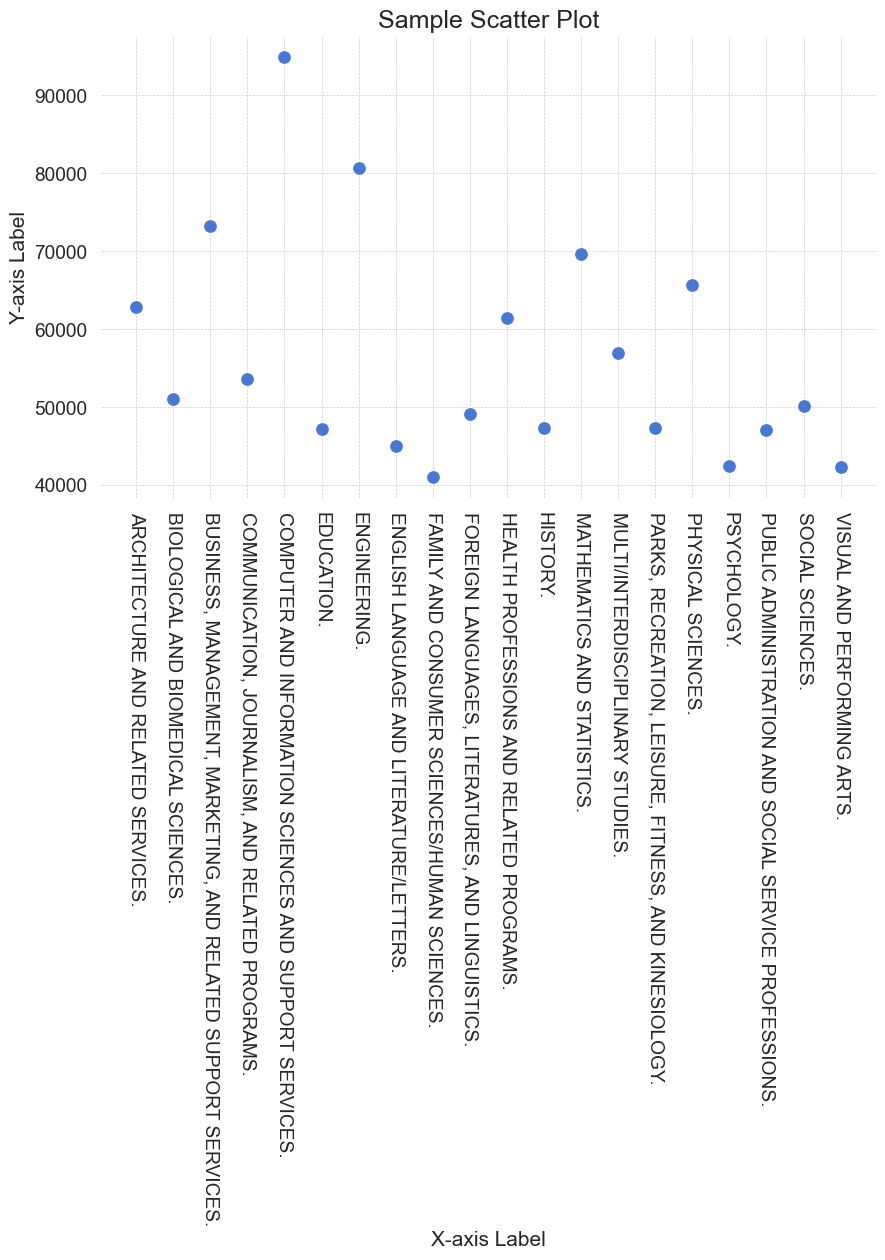

In [82]:
# Scatter plot of UofU majors with 4yr earnings
uofu_data = univ_field_4yr[univ_field_4yr['INSTNM_'] == 'University of Utah']

# 1. Styling
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# 2. Palette
palette = sns.color_palette("muted")

# 3. Size and Aspect Ratio
plt.figure(figsize=(10, 6))

# Creating scatter plot
sns.scatterplot(data=uofu_data, x="CIPDEF_", y='EARN_MDN_4YR_median', color=palette[0], edgecolor='w', s=100)

# 4. Plot Customizations
plt.title('Sample Scatter Plot', fontsize=18)
plt.xlabel('X-axis Label', fontsize=15)
plt.ylabel('Y-axis Label', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 5. Despine
sns.despine(left=True, bottom=True)
plt.xticks(rotation=-90)
plt.tight_layout()
plt.show()